<a href="https://colab.research.google.com/github/momo76620/Machine-learning/blob/main/Mean_Reverting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

In [157]:
def yfv2(pair, i, years, months, day, h, min) :
  sg = pair + "=X"
  data = yf.Ticker(sg)
  start_datetime = datetime.datetime(years, months,day, h, min)
  end_datetime = start_datetime + datetime.timedelta(minutes=i)
  dataDF = yf.download(tickers= sg, start=start_datetime, end=end_datetime, interval='1m')
  array10 = dataDF.index.to_numpy()  # Time
  array1 = dataDF['Close'].to_numpy()  # Price
  array2 = dataDF['Open'].to_numpy()
  return array10, array1, array2



In [158]:
 array10, array1, array2 = yfv2("AUDUSD", 800,2024,2, 7, 2, 0)

[*********************100%%**********************]  1 of 1 completed


In [159]:
df = pd.DataFrame({'Time': array10, 'Price': array1, 'Open': array2})

In [98]:
print(df.columns)

Index(['Time', 'Price', 'Open'], dtype='object')


In [160]:
#df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
#On convertit les colonnes en numériques

<Axes: >

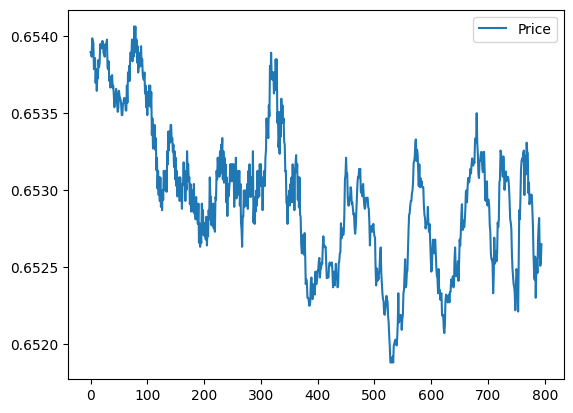

In [161]:
df[['Price']].plot()

In [162]:
df['ma_20'] = df.Price.rolling(20).mean()
df['vol'] = df.Price.rolling(20).std()
df['upper_bb'] = df.ma_20 + (2* df.vol)
df['lower_bb'] = df.ma_20 - (2* df.vol)



<Axes: >

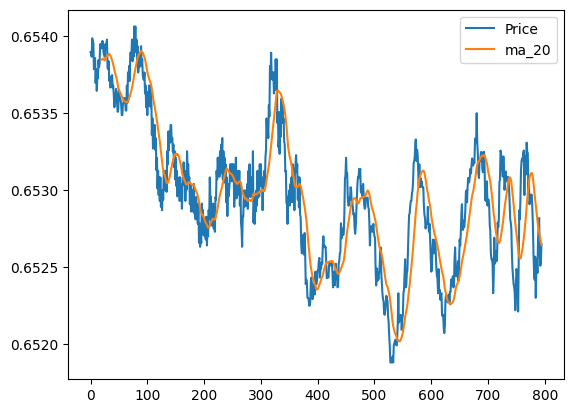

In [163]:
df[['Price','ma_20']].plot()

<Axes: >

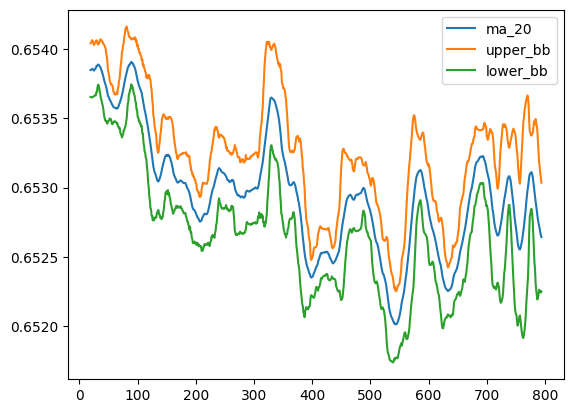

In [164]:
df[['ma_20', 'upper_bb','lower_bb']].plot()

In [165]:
def calculate_rsi(df, window=14):
    delta = df['Price'].diff(1)  # Différence de prix entre deux jours consécutifs
    gain = (delta.where(delta > 0, 0)).fillna(0)  # Gains seulement
    loss = (-delta.where(delta < 0, 0)).fillna(0)  # Pertes seulement

    # Moyenne des gains
    avg_gain = gain.rolling(window=window).mean()
    # Moyenne des pertes
    avg_loss = loss.rolling(window=window).mean()

    # Calcul de la force relative (RS)
    rs = avg_gain / avg_loss

    # Calcul du RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = calculate_rsi(df, window=6)

In [166]:
print(df.columns)

Index(['Time', 'Price', 'Open', 'ma_20', 'vol', 'upper_bb', 'lower_bb', 'rsi'], dtype='object')


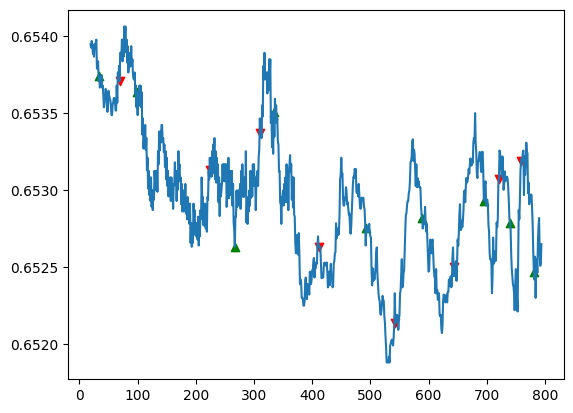

In [167]:
conditions = [(df.rsi<30) & (df.Price < df.lower_bb), (df.rsi>70) & (df.Price > df.upper_bb)]
choices = ['Buy', 'Sell']
df['signal'] = np.select(conditions, choices)
df.dropna(inplace=True)
df.signal = df.signal.shift()

position = False
buydates, selldates = [], []
buyprices, sellprices = [], []

for index,row in df.iterrows():
  if not position and row['signal'] == 'Buy':
    buydates.append(index)
    buyprices.append(row.Open)
    position = True
  if position and row['signal'] == 'Sell':
    selldates.append(index)
    sellprices.append (row.Open)
    position = False

plt.plot(df.Price)
plt.scatter(df.loc[buydates].index, df.loc[buydates].Price, marker='^', c='g')
plt.scatter(df.loc[selldates].index, df.loc[selldates].Price, marker='v', c='r')

In [168]:
[(sell - buy) / buy for sell,buy in zip(sellprices, buyprices)]

[-4.567590909418291e-05,
 -0.0005551590712691272,
 0.0010386938814875215,
 -0.0007963173947582661,
 -0.0007696472599215139,
 -0.0004894625407314821,
 1.3053173883793891e-05,
 0.0005877940819536716]

In [169]:



# On calcule les rendements individuels de chaque transaction
rendements = [(sell - buy) / buy for sell, buy in zip(sellprices, buyprices)]

# Somme des rendements individuels
rendement_total = sum(rendements)


print(f'Rendement total: {rendement_total_percent:.2f}%')




Rendement total: -0.10%


In [170]:


# Initialisation des paramètres du portefeuille
solde_initial = 10000  # Solde initial en dollars ou en devise de base
valeur_par_trade = 1000  # Valeur allouée pour chaque trade en devise de base

# Initialisation du portefeuille
portefeuille = {
    'cash': solde_initial,
    'position': 0,
    'valeur_portefeuille': solde_initial,
    'date_achat': None,  # Ajouter une clé pour la date d'achat
    'prix_achat': None   # Ajouter une clé pour le prix d'achat
}

# Liste pour enregistrer l'historique du portefeuille et les détails des trades
historique_portefeuille = []
trades = []

# Simuler les trades
for index, row in df.iterrows():
    if row['signal'] == 'Buy' and not portefeuille['position'] and portefeuille['cash'] >= valeur_par_trade:
        # Acheter pour la valeur par trade divisée par le prix d'ouverture
        montant_achete = valeur_par_trade / row['Open']
        portefeuille['cash'] -= valeur_par_trade
        portefeuille['position'] = montant_achete
        portefeuille['date_achat'] = index  # Enregistrer la date d'achat
        portefeuille['prix_achat'] = row['Open']  # Enregistrer le prix d'achat

    elif row['signal'] == 'Sell' and portefeuille['position'] > 0:
        # Vendre toutes les positions et convertir le montant vendu en devise de base
        montant_vendu = portefeuille['position'] * row['Open']
        profit = montant_vendu - (portefeuille['position'] * portefeuille['prix_achat'])  # Calculer le profit de la transaction
        portefeuille['cash'] += montant_vendu
        portefeuille['position'] = 0

 # Enregistrer le trade
        trades.append({
            'buy_date': portefeuille['date_achat'],  # Utiliser la date d'achat enregistrée
            'buy_price': portefeuille['prix_achat'],  # Utiliser le prix d'achat enregistré
            'sell_date': index,
            'sell_price': row['Open'],
            'profit': profit,
            'is_winner': profit > 0
        })

# Calcul de la valeur finale du portefeuille
if portefeuille['position'] > 0:
    # Si une position est encore ouverte, la vendre au dernier prix connu
    dernier_prix = df.iloc[-1]['Open']
    montant_vendu = portefeuille['position'] * dernier_prix
    portefeuille['cash'] += montant_vendu
    portefeuille['position'] = 0
portefeuille['valeur_portefeuille'] = portefeuille['cash']

# Créer un DataFrame pour les trades
trades_df = pd.DataFrame(trades)

# Calcul des statistiques des trades
nombre_trades = len(trades_df)
nombre_gagnants = trades_df['is_winner'].sum()
nombre_perdants = nombre_trades - nombre_gagnants
gain_total = trades_df['profit'].sum()
rendement_total = gain_total / solde_initial

print(f"Nombre total de trades: {nombre_trades}")
print(f"Nombre de trades gagnants: {nombre_gagnants}")
print(f"Nombre de trades perdants: {nombre_perdants}")
print(f"Gain total: {gain_total}")
print(f"Rendement total: {rendement_total:.2%}")


Nombre total de trades: 8
Nombre de trades gagnants: 3
Nombre de trades perdants: 5
Gain total: -1.0167210384494183
Rendement total: -0.01%


In [171]:


# Supposons que la liste 'trades' est déjà remplie avec les détails des trades
# Chaque élément de 'trades' est un dictionnaire avec les clés 'buy_date', 'buy_price', 'sell_date', 'sell_price', 'profit', et 'is_winner'

# Convertir la liste de trades en DataFrame pour un affichage tabulaire
trades_df = pd.DataFrame(trades)

trades_df.index += 1

# Afficher le DataFrame des trades
print(trades_df)


   buy_date  buy_price  sell_date  sell_price    profit  is_winner
1        34   0.653778         69    0.653749 -0.045676      False
2        99   0.653531        225    0.653168 -0.555159      False
3       267   0.652631        311    0.653309  1.038694       True
4       334   0.653219        411    0.652699 -0.796317      False
5       493   0.652699        543    0.652197 -0.769647      False
6       589   0.652840        643    0.652520 -0.489463      False
7       696   0.652980        721    0.652989  0.013053       True
8       740   0.652737        759    0.653121  0.587794       True


In [172]:
# Supposons que df est votre DataFrame original avec les signaux
# et que trades_df est votre DataFrame contenant la liste des trades.

# Vérifier chaque trade
for index, trade in trades_df.iterrows():
    buy_signal = df.loc[trade['buy_date'], 'signal'] == 'Buy'
    sell_signal = df.loc[trade['sell_date'], 'signal'] == 'Sell'
    if not buy_signal or not sell_signal:
        print(f"Le trade à l'index {index} ne correspond pas aux signaux générés.")
    else:
        print(f"Le trade à l'index {index} correspond aux signaux générés.")


Le trade à l'index 1 correspond aux signaux générés.
Le trade à l'index 2 correspond aux signaux générés.
Le trade à l'index 3 correspond aux signaux générés.
Le trade à l'index 4 correspond aux signaux générés.
Le trade à l'index 5 correspond aux signaux générés.
Le trade à l'index 6 correspond aux signaux générés.
Le trade à l'index 7 correspond aux signaux générés.
Le trade à l'index 8 correspond aux signaux générés.


In [173]:
import pandas as pd

# Supposons que 'df' est votre DataFrame qui contient déjà les prix, les indicateurs et les signaux.
# Et que 'trades' est la liste qui contient les informations de chaque trade, que vous avez rempli précédemment.

# Ajoutons les informations supplémentaires aux trades en parcourant chaque trade
trades_detailed = []
for trade in trades:
    trade_details = {
        'buy_date': trade['buy_date'],
        'buy_price': trade['buy_price'],
        'sell_date': trade['sell_date'],
        'sell_price': trade['sell_price'],
        'profit': trade['profit'],
        'is_winner': trade['is_winner'],
        # Récupérons les informations supplémentaires de 'df'
        'ma_20_at_buy': df.loc[trade['buy_date'], 'ma_20'],
        'upper_bb_at_buy': df.loc[trade['buy_date'], 'upper_bb'],
        'lower_bb_at_buy': df.loc[trade['buy_date'], 'lower_bb'],
        'rsi_at_buy': df.loc[trade['buy_date'], 'rsi'],
        'ma_20_at_sell': df.loc[trade['sell_date'], 'ma_20'],
        'upper_bb_at_sell': df.loc[trade['sell_date'], 'upper_bb'],
        'lower_bb_at_sell': df.loc[trade['sell_date'], 'lower_bb'],
        'rsi_at_sell': df.loc[trade['sell_date'], 'rsi'],
    }
    trades_detailed.append(trade_details)

# Créons maintenant un DataFrame à partir de cette liste détaillée
trades_df = pd.DataFrame(trades_detailed)

trades_df.index += 1

# Affichons le DataFrame pour vérifier
print(trades_df)


   buy_date  buy_price  sell_date  sell_price    profit  is_winner  \
1        34   0.653778         69    0.653749 -0.045676      False   
2        99   0.653531        225    0.653168 -0.555159      False   
3       267   0.652631        311    0.653309  1.038694       True   
4       334   0.653219        411    0.652699 -0.796317      False   
5       493   0.652699        543    0.652197 -0.769647      False   
6       589   0.652840        643    0.652520 -0.489463      False   
7       696   0.652980        721    0.652989  0.013053       True   
8       740   0.652737        759    0.653121  0.587794       True   

   ma_20_at_buy  upper_bb_at_buy  lower_bb_at_buy  rsi_at_buy  ma_20_at_sell  \
1      0.653881         0.654043         0.653719   24.239437       0.653608   
2      0.653791         0.654020         0.653562   41.076099       0.652910   
3      0.652999         0.653308         0.652691   31.026670       0.653094   
4      0.653634         0.654030         0.653238

## Ajouter les stop-losses / Take profit
## Ajouter les coûts de transaction
## Exporter au format Excel